# Proyectos Diploma Ciencia de Datos Avanzado

### 14. Proyecciones COVID-19 (4)

EL COVID-19 es una enfermedad que tiene a todo el mundo en alerta. Un aspecto
importante que las autoridades deben considerar es cuánto se proyecta que la
enfermedad crezca y qué medidas tomar para disminuir el impacto de la crisis sanitaria
que se viene a futuro. 
Este proyecto considera el diseño e implementación de modelos
de proyecciones de COVID-19 y evaluar el impacto de distintas medidas. Esto se
realizará mediante _resolución de ecuaciones diferenciales_ que consideren distintas
etapas de la infección. Un ejemplo básico de esto es el __modelo SEIR
(Susceptible-Expuesto-Infeccioso-Recuperado)__. Este modelo _debe ser mejorado_ para
incorporar variables tales como _limitaciones de exámenes realizados, pacientes
hospitalizados, pacientes en estado crítico y fallecimientos_.

### Background 

There is already information available about adapted SEIR models being used for modelling and fit diverse Covid19 data curves [1,2,3,4,5]. However, all these agree that is necesary to analyse each country under their own specific parameters, because the different approach taken against the pandemic, i.e. lockdown situations and population response to those measures is country specific. For example, data for Chile has being analysed by Guerrero and Manríquez (2020)

In [2]:
#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Here we would try to do a city specific analysis that would aggregate and scale up following the principle __city > region > country__ and always considering their population as normalization value, this to make situations comparable between them

In [65]:
#Data for Chile is avaialble at https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto25/CasosActualesPorComuna_std.csv
#and constantly updated by the national government

df = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto25/CasosActualesPorComuna_std.csv")

### Exploratory Analysis

In [66]:
df.head() #variables are "Region", "Codigo region", ¨"Comuna", "Codigo Comuna", "Poblacion", "Fecha". "Casos actuales"
 
df.tail() #at 31-10-2020 there are 21545 observations

df.shape # df dimmensions (21546, 7)

df.columns 
#Index(['Region', 'Codigo region', 'Comuna', 'Codigo comuna', 'Poblacion',
#'Fecha', 'Casos actuales'],
#dtype='object')

df.describe()


,Codigo region,Codigo comuna,Poblacion,Casos actuales
count,21546.000000,19722.000000,2.063400e+04,21226.000000
mean,8.772487,9034.997110,1.075045e+05,104.352963
std,3.913314,3812.722547,4.651215e+05,676.226018
min,1.000000,1101.000000,1.370000e+02,0.000000
25%,6.000000,6109.000000,1.005500e+04,1.000000
50%,8.000000,8313.500000,2.107550e+04,11.000000
75%,13.000000,13103.000000,8.183800e+04,50.000000
max,16.000000,16305.000000,8.125072e+06,33315.000000


### Data wrangling and cleaning

In [67]:
df.count() 
#All variables seem to have 21546 observations but 'Codigo comuna' and 'Casos actuales'
#which show 19722  and 21226 observetaions respectivly possiblly due to presence of NA values

Region            21546
Codigo region     21546
Comuna            21546
Codigo comuna     19722
Poblacion         20634
Fecha             21546
Casos actuales    21226
dtype: int64

In [68]:
df[df['Codigo comuna'].isna()] 
#Missing values are indicating absence of city_code and are ported as unknown and the region name
#This probably because there are cases with unknown procedence within a specific region
#Also total values are reported as NA
#df contains 1824 observations with NA values

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,Fecha,Casos actuales
4,Arica y Parinacota,15,Desconocido Arica y Parinacota,NaN,NaN,2020-04-13,NaN
5,Arica y Parinacota,15,Total,NaN,252110.0,2020-04-13,88.0
13,Tarapaca,1,Desconocido Tarapaca,NaN,NaN,2020-04-13,NaN
14,Tarapaca,1,Total,NaN,382773.0,2020-04-13,30.0
24,Antofagasta,2,Desconocido Antofagasta,NaN,NaN,2020-04-13,NaN
...,...,...,...,...,...,...,...
21520,Los Lagos,10,Total,NaN,891440.0,2020-10-26,1392.0
21531,Aysen,11,Desconocido Aysen,NaN,NaN,2020-10-26,0.0
21532,Aysen,11,Total,NaN,107297.0,2020-10-26,118.0
21544,Magallanes y la Antartica,12,Desconocido Magallanes,NaN,NaN,2020-10-26,4.0


In [77]:
df[df['Casos actuales'].isna()] #There are 320 rows with NA values

df_clean = df.fillna(value = {'Casos actuales':0}) 
# in the case of cases, this correspond to days with 0 or not reported No of cases
# Hence, these were replaced by a 0 value


df_clean[df_clean['Casos actuales'].isna()] #No NA found


,Region,Codigo region,Comuna,Codigo comuna,Poblacion,Fecha,Casos actuales


In [79]:
#Variable names will be changed for good data practices
#old variables ['Region', 'Codigo region', 'Comuna', 'Codigo comuna', 'Poblacion','Fecha', 'Casos actuales']
#old variables

df_clean.rename(columns={"Region":"region", 
                   "Codigo region":"region_code",
                   "Comuna":"city",
                   "Codigo comuna":"city_code",
                   "Poblacion":"population",
                   "Fecha":"date",
                   "Casos actuales":"cases"
                  }, inplace = True)
df_clean.head()

,region,region_code,city,city_code,population,date,cases
0,Arica y Parinacota,15,Arica,15101.0,247552.0,2020-04-13,88.0
1,Arica y Parinacota,15,Camarones,15102.0,1233.0,2020-04-13,0.0
2,Arica y Parinacota,15,General Lagos,15202.0,810.0,2020-04-13,0.0
3,Arica y Parinacota,15,Putre,15201.0,2515.0,2020-04-13,0.0
4,Arica y Parinacota,15,Desconocido Arica y Parinacota,NaN,NaN,2020-04-13,0.0


In [81]:
#Normalise city cases by 1000 inhabitants

df_clean['cases_1000'] = df_clean['cases']/(df_clean['population']/1000)
df_clean

,region,region_code,city,city_code,population,date,cases,cases_1000
0,Arica y Parinacota,15,Arica,15101.0,247552.0,2020-04-13,88.0,0.355481
1,Arica y Parinacota,15,Camarones,15102.0,1233.0,2020-04-13,0.0,0.000000
2,Arica y Parinacota,15,General Lagos,15202.0,810.0,2020-04-13,0.0,0.000000
3,Arica y Parinacota,15,Putre,15201.0,2515.0,2020-04-13,0.0,0.000000
4,Arica y Parinacota,15,Desconocido Arica y Parinacota,NaN,NaN,2020-04-13,0.0,NaN
...,...,...,...,...,...,...,...,...
21541,Magallanes y la Antartica,12,San Gregorio,12104.0,681.0,2020-10-26,1.0,1.468429
21542,Magallanes y la Antartica,12,Timaukel,12303.0,282.0,2020-10-26,5.0,17.730496
21543,Magallanes y la Antartica,12,Torres del Paine,12402.0,1021.0,2020-10-26,0.0,0.000000
21544,Magallanes y la Antartica,12,Desconocido Magallanes,NaN,NaN,2020-10-26,4.0,NaN


In [82]:
#drop city and region codes
df_clean = df_clean[['region','city','population','date','cases','cases_1000']]

df_clean


,region,city,population,date,cases,cases_1000
0,Arica y Parinacota,Arica,247552.0,2020-04-13,88.0,0.355481
1,Arica y Parinacota,Camarones,1233.0,2020-04-13,0.0,0.000000
2,Arica y Parinacota,General Lagos,810.0,2020-04-13,0.0,0.000000
3,Arica y Parinacota,Putre,2515.0,2020-04-13,0.0,0.000000
4,Arica y Parinacota,Desconocido Arica y Parinacota,NaN,2020-04-13,0.0,NaN
...,...,...,...,...,...,...
21541,Magallanes y la Antartica,San Gregorio,681.0,2020-10-26,1.0,1.468429
21542,Magallanes y la Antartica,Timaukel,282.0,2020-10-26,5.0,17.730496
21543,Magallanes y la Antartica,Torres del Paine,1021.0,2020-10-26,0.0,0.000000
21544,Magallanes y la Antartica,Desconocido Magallanes,NaN,2020-10-26,4.0,NaN


### Data analysis

Text(0, 0.5, 'Region')

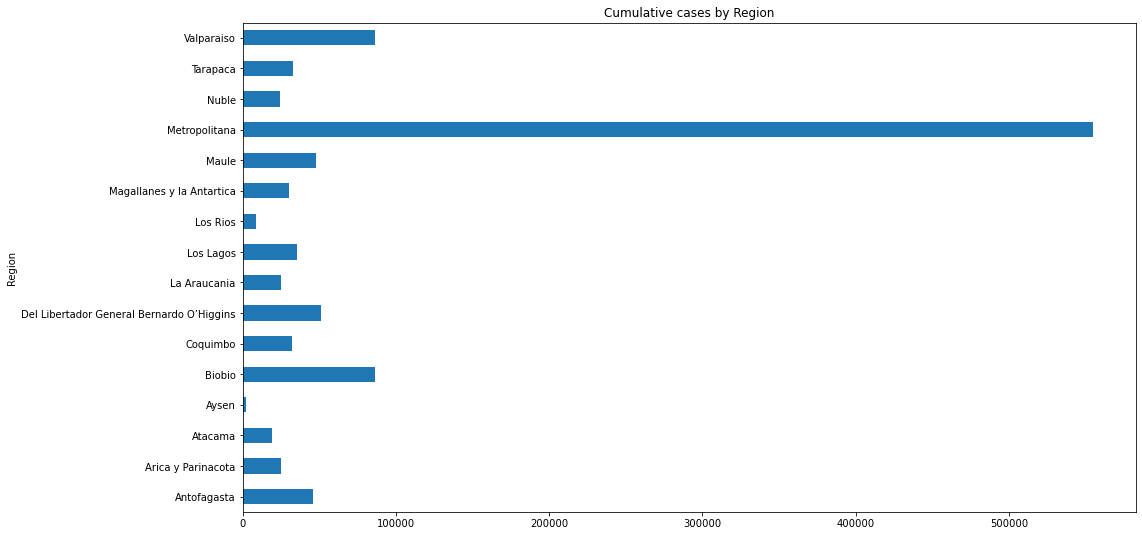

In [149]:
# Data will be subsetted in Regional data and city. 
# For the regional data the total population value would be used to normalise the cumulative city cases
# For the the different cities, data would be used as it is due to the Unknown city population parameter

df_cumulative = df_clean[df_clean['city'] == 'Total'].groupby('region')['cases'].sum()

df_cumulative.plot.barh(x='region', y='cases', figsize=(16, 9))
plt.title("Cumulative cases by Region")
plt.xlabel("")
plt.ylabel("Region")

In [ ]:
df_cumulative_1000 = df_clean[df_clean['city'] == 'Total'].groupby('region')['cases_1000'].sum()
df_cumulative_1000.plot.barh(x='region', y='cases_1000', figsize=(16, 9))
plt.title("Cumulative cases by Region per 1000 inhabitants")
plt.xlabel("")
plt.ylabel("Region")

#### Daily cases can be analysed by filtering by an specific date

In [ ]:
#For instance filtering by the last date 2020-10-26

df_trial = df_clean[df_clean['date'] == '2020-10-26']

In [139]:
#Summarising data by region

#df_region = df_trial.groupby('region')['cases'].sum()
df_region = df_trial[df_trial['city'] == 'Total']
df_region

,region,city,population,date,cases,cases_1000
21173,Arica y Parinacota,Total,252110.0,2020-10-26,319.0,1.265321
21182,Tarapaca,Total,382773.0,2020-10-26,356.0,0.930055
21193,Antofagasta,Total,691854.0,2020-10-26,317.0,0.458189
21204,Atacama,Total,314709.0,2020-10-26,169.0,0.537004
21221,Coquimbo,Total,836096.0,2020-10-26,150.0,0.179405
21261,Valparaiso,Total,1960170.0,2020-10-26,821.0,0.418841
21315,Metropolitana,Total,8125072.0,2020-10-26,2617.0,0.322089
21350,Del Libertador General Bernardo O’Higgins,Total,991063.0,2020-10-26,576.0,0.581194
21382,Maule,Total,1131939.0,2020-10-26,604.0,0.533598
21405,Nuble,Total,511551.0,2020-10-26,349.0,0.682239


Text(0, 0.5, 'Region')

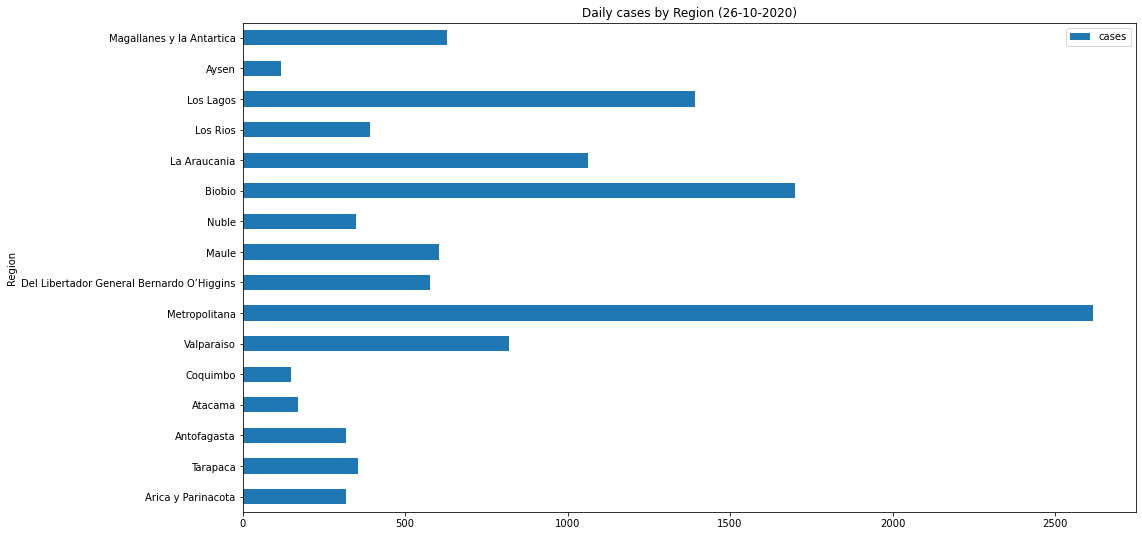

In [153]:
df_region.plot.barh(x='region', y='cases', figsize=(16, 9))
plt.title("Daily cases by Region (26-10-2020)")
plt.xlabel("")
plt.ylabel("Region")

Text(0, 0.5, 'City')

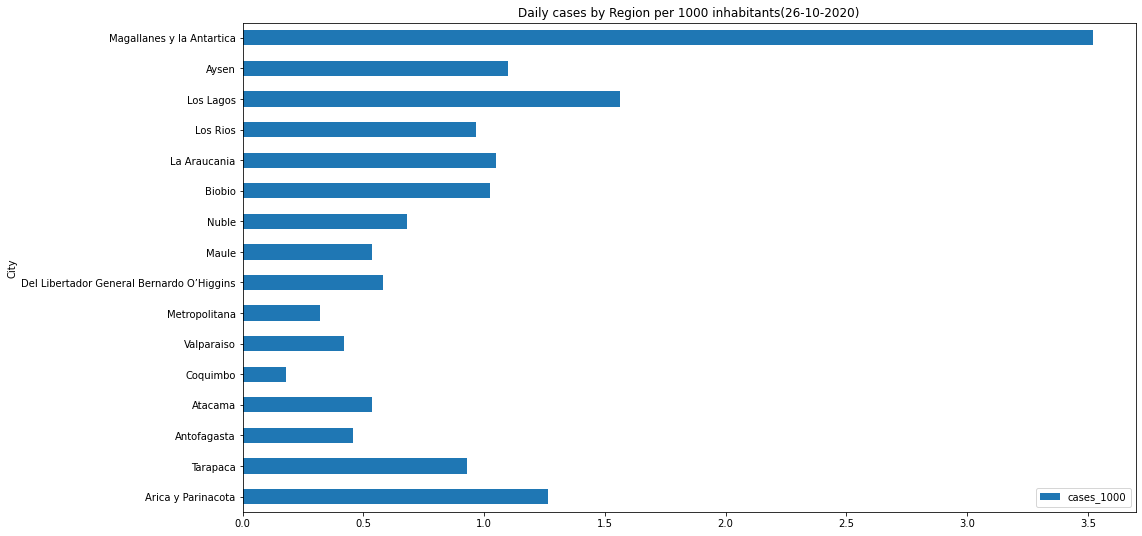

In [144]:
df_region.plot.barh(x='region', y='cases_1000', figsize=(16, 9))
plt.title("Daily cases by Region per 1000 inhabitants(26-10-2020)")
plt.xlabel("")
plt.ylabel("City")

Data can be expanded and analysed for each city within a region

Text(0, 0.5, 'City')

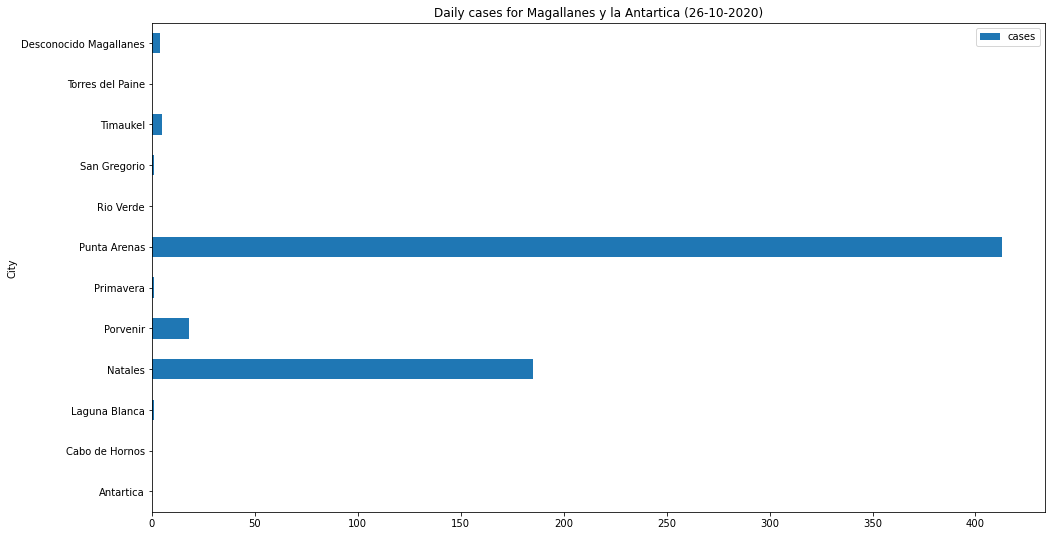

In [125]:
#i.e. Megallanes

df_city = df_trial[(df_trial['region'] == 'Magallanes y la Antartica') & (df_trial['city'] != 'Total')]

df_city.plot.barh(x='city', y='cases', figsize=(16, 9))
plt.title("Daily cases for Magallanes y la Antartica (26-10-2020)")
plt.xlabel("")
plt.ylabel("City")

#### Time series can be analysed using either region or city data

The resulting dataframe is pivoted so we get one row per __date__, columns by __region__ and the number of new cases per 1000 inhabitants for that date and region in the cells. Again, show the first 10 rows from our new dataframe ts_region to check the result of our pivot.

In [181]:
#by region

ts_region = df_clean[df_clean['city'] == 'Total']

ts_region = ts_region[[
    'region','date','cases', 'cases_1000'
]].pivot(index='date', columns='region', values=['cases', 'cases_1000'])

ts_region.head()

cases                                                   \
region     Antofagasta Arica y Parinacota Atacama Aysen Biobio Coquimbo   
date                                                                      
2020-04-13        79.0               88.0     9.0   2.0  230.0     19.0   
2020-04-15        89.0               81.0     9.0   0.0  176.0     19.0   
2020-04-17       104.0               74.0     9.0   0.0  147.0     14.0   
2020-04-20       131.0               66.0     7.0   0.0  132.0     14.0   
2020-04-24       180.0               79.0     7.0   0.0  152.0      9.0   

                                                                             \
region     Del Libertador General Bernardo O’Higgins La Araucania Los Lagos   
date                                                                          
2020-04-13                                       9.0        277.0     131.0   
2020-04-15                                       9.0        238.0      93.0   
2020-04-17                                       9.0        210.0      80.0   
2020-04-20                                       9.0        239.0      66.0   
2020-04-24                                      29.0        240.0      51.0   

                     ...                                cases_1000  \
region     Los Rios  ... Del Libertador General Bernardo O’Higgins   
date                 ...                                             
2020-04-13     50.0  ...                                  0.009081   
2020-04-15     37.0  ...                                  0.009081   
2020-04-17     32.0  ...                                  0.009081   
2020-04-20     25.0  ...                                  0.009081   
2020-04-24     18.0  ...                                  0.029262   

                                                                       \
region     La Araucania Los Lagos  Los Rios Magallanes y la Antartica   
date                                                                    
2020-04-13     0.273083  0.146953  0.123203                  1.205414   
2020-04-15     0.234635  0.104326  0.091170                  1.037216   
2020-04-17     0.207031  0.089742  0.078850                  1.026003   
2020-04-20     0.235620  0.074038  0.061601                  1.059643   
2020-04-24     0.236606  0.057211  0.044353                  0.840986   

                                                                   
region         Maule Metropolitana     Nuble  Tarapaca Valparaiso  
date                                                               
2020-04-13  0.043289      0.200121  0.371419  0.078375   0.044894  
2020-04-15  0.042405      0.191629  0.273678  0.091438   0.042343  
2020-04-17  0.103362      0.232859  0.216987  0.099276   0.052036  
2020-04-20  0.147534      0.251690  0.160297  0.109726   0.055097  
2020-04-24  0.165203      0.280613  0.152477  0.159363   0.056628  

[5 rows x 32 columns]

We can describe the columns to get an idea of what's there.

In [166]:
ts_region.describe().transpose()

count         mean  \
           region                                                          
cases      Antofagasta                                 57.0   802.385965   
           Arica y Parinacota                          57.0   436.228070   
           Atacama                                     57.0   340.649123   
           Aysen                                       57.0    41.122807   
           Biobio                                      57.0  1510.157895   
           Coquimbo                                    57.0   570.140351   
           Del Libertador General Bernardo O’Higgins   57.0   896.280702   
           La Araucania                                57.0   434.403509   
           Los Lagos                                   57.0   623.736842   
           Los Rios                                    57.0   150.280702   
           Magallanes y la Antartica                   57.0   528.280702   
           Maule                                       57.0   842.719298   
           Metropolitana                               57.0  9735.228070   
           Nuble                                       57.0   428.859649   
           Tarapaca                                    57.0   570.280702   
           Valparaiso                                  57.0  1519.035088   
cases_1000 Antofagasta                                 57.0     1.159762   
           Arica y Parinacota                          57.0     1.730308   
           Atacama                                     57.0     1.082426   
           Aysen                                       57.0     0.383261   
           Biobio                                      57.0     0.907713   
           Coquimbo                                    57.0     0.681908   
           Del Libertador General Bernardo O’Higgins   57.0     0.904363   
           La Araucania                                57.0     0.428261   
           Los Lagos                                   57.0     0.699696   
           Los Rios                                    57.0     0.370300   
           Magallanes y la Antartica                   57.0     2.961846   
           Maule                                       57.0     0.744492   
           Metropolitana                               57.0     1.198171   
           Nuble                                       57.0     0.838352   
           Tarapaca                                    57.0     1.489867   
           Valparaiso                                  57.0     0.774951   

                                                              std  \
           region                                                   
cases      Antofagasta                                 560.684172   
           Arica y Parinacota                          279.512970   
           Atacama                                     285.122874   
           Aysen                                        68.791629   
           Biobio                                      942.390118   
           Coquimbo                                    438.905515   
           Del Libertador General Bernardo O’Higgins   706.818697   
           La Araucania                                333.765468   
           Los Lagos                                   500.944947   
           Los Rios                                    152.859734   
           Magallanes y la Antartica                   588.868278   
           Maule                                       471.723427   
           Metropolitana                              7719.816345   
           Nuble                                       258.588023   
           Tarapaca                                    282.289603   
           Valparaiso                                  922.855815   
cases_1000 Antofagasta                                   0.810408   
           Arica y Parinacota                            1.108695   
           Atacama                                       0.905989   
           Aysen    

Get to know your data by visualization, in this case the number of new cases per day for my home region Aysen.

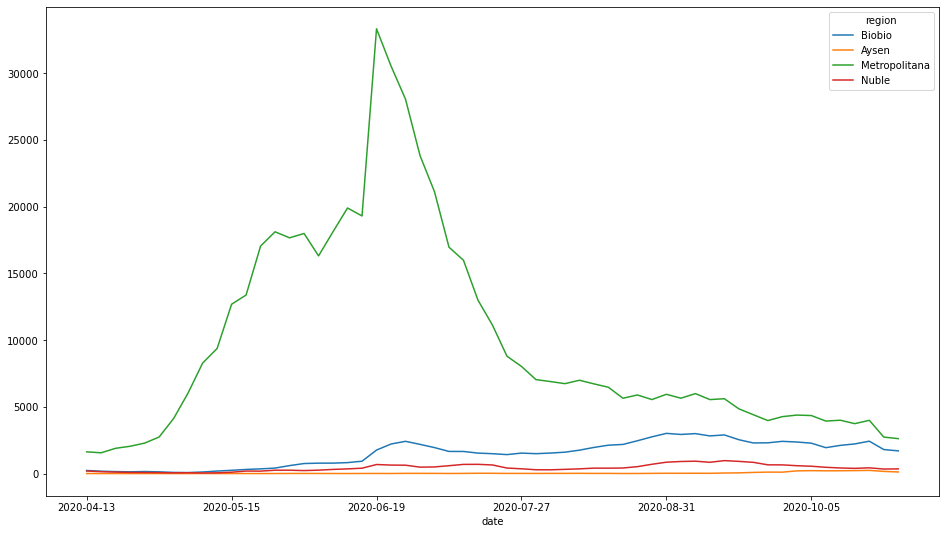

In [202]:
ts_region['cases'][['Biobio', 'Aysen', 'Metropolitana', 'Nuble']].plot(figsize=(16, 9))

As observed in the previous plot, data cannot be easily compared between different regions. Therefore, If you want to compare the number of cases you must normalise by the number of inhabitants on each region

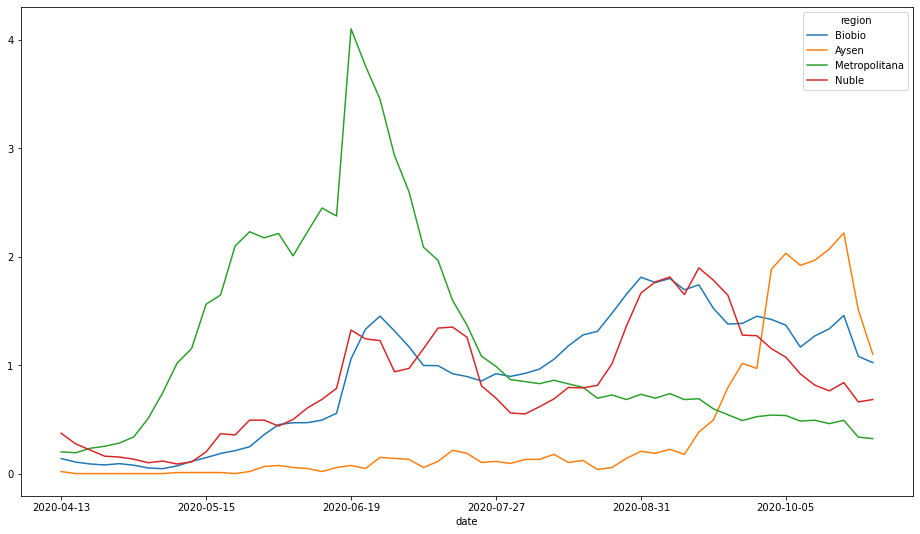

In [203]:
ts_region['cases_1000'][['Biobio', 'Aysen', 'Metropolitana', 'Nuble']].plot(figsize=(16, 9))

To see the growth in number of cases, we use a cumulative sum with cumsum, in this case we show Aysen, Antofagasta, Valparaiso and Bio Bio.


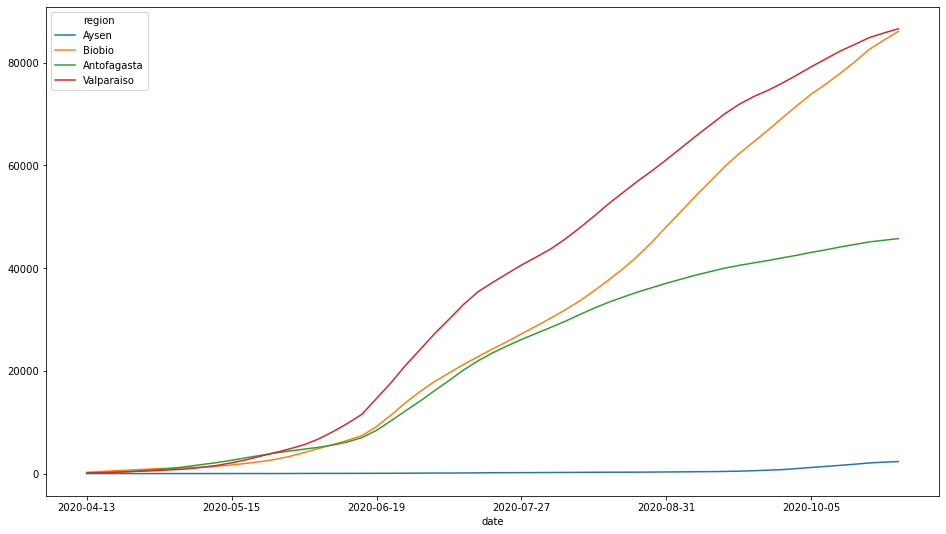

In [175]:
ts_region['cases'][['Aysen', 'Biobio', 'Antofagasta', 'Valparaiso']].cumsum().plot(figsize=(16, 9))

From the previous analysis you can observe that it is always better to analyse each case normalised by the number of inhabitants making comparison among different regions possible. To prove this we plot the Metropolitan region (Santiago) which has the highest country population and also the highest number of cases with all other regions
 

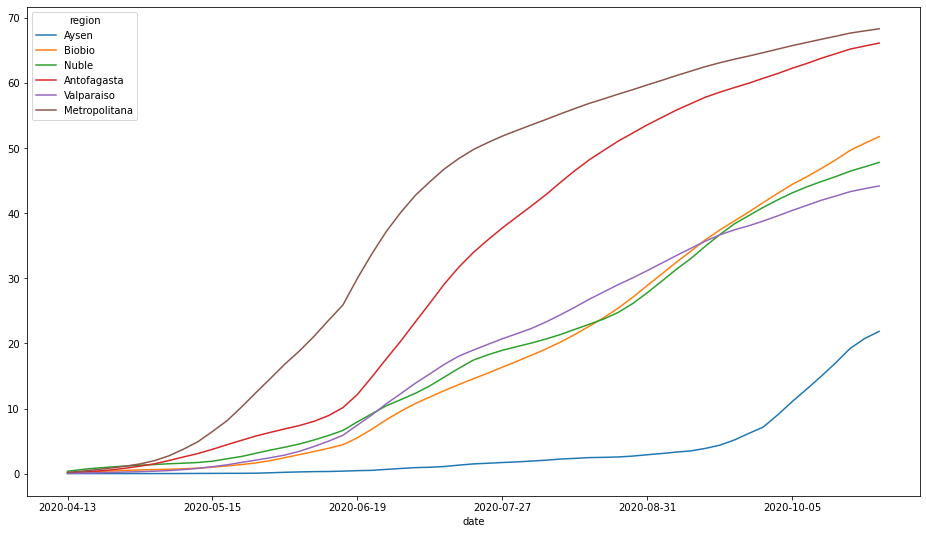

In [204]:
ts_region['cases_1000'][['Aysen', 'Biobio', 'Nuble', 'Antofagasta', 'Valparaiso', 'Metropolitana']].cumsum().plot(figsize=(16, 9))

What about infection rate? The example below gives the average number of cases for last week divided by the infectious cases a week before, a proxy for the infamous __R measure__ [7]. Again we use rolling window for smoothing and add a couple of example options for plot.

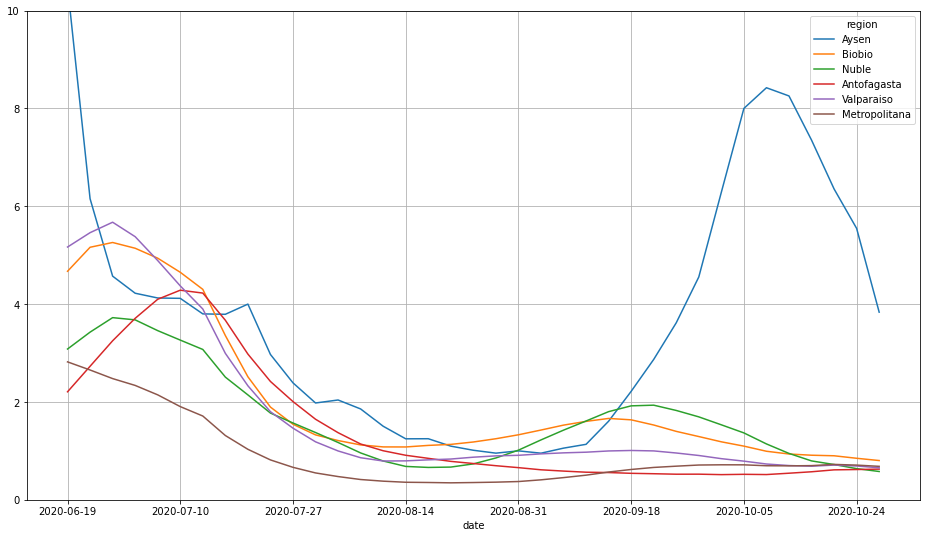

In [206]:
regions = ['Aysen', 'Biobio','Nuble', 'Antofagasta', 'Valparaiso', 'Metropolitana']

(ts_region.rolling(7).mean() / ts_region.shift(7).rolling(14).mean(
    ))['cases'][regions].loc['2020-04-13':].plot(
    figsize=(16, 9), grid=True, ylim=(0, 10))

Based on a recent paper by Daddi and Giavalisco, the double log of the cumulative cases divided by the daily increase should approach linearity. Ignoring the noise of spurious cases in the beginning, at least some parts of the outbreak looks promising.


<ipython-input-207-082b6511354f>:1: RuntimeWarning: divide by zero encountered in log
  np.log(np.log(ts_region.cumsum() / ts_region))['cases'][regions].loc['2020-04-13':].rolling(7).mean().plot(


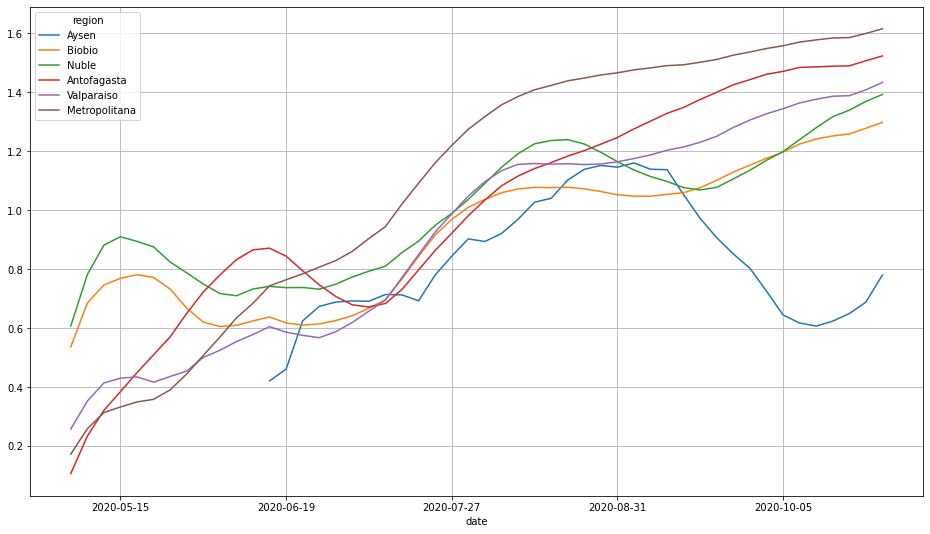

In [207]:
np.log(np.log(ts_region.cumsum() / ts_region))['cases'][regions].loc['2020-04-13':].rolling(7).mean().plot(
    figsize=(16, 9), grid=True)

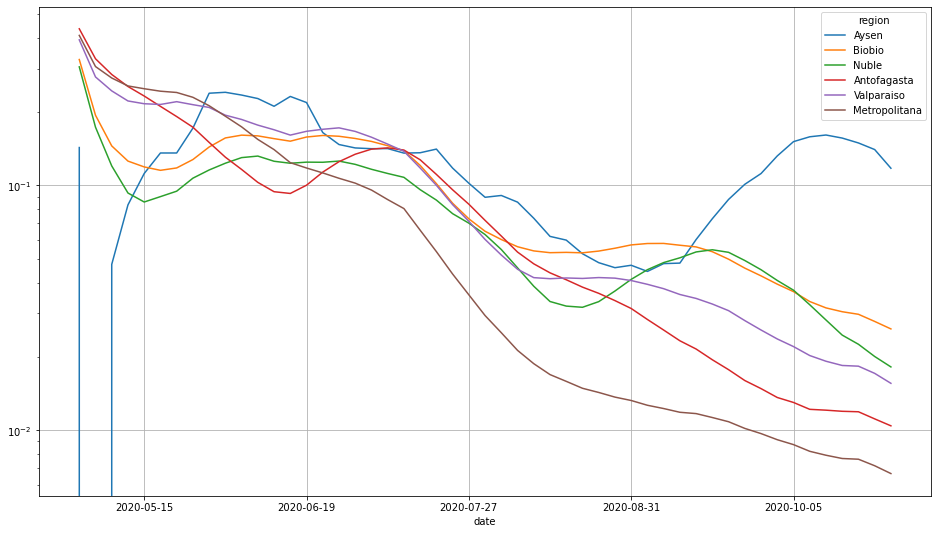

In [208]:
(ts_region / ts_region.cumsum())['cases'][regions].rolling(7).mean().loc['2020-04-13':].plot(
    figsize=(16, 9), grid=True, logy=True)

#### References

1. Reiner, R. C., Barber, R. M., Collins, J. K., Zheng, P., Adolph, C., Albright, J., Antony, C. M., Aravkin, A. Y., Bachmeier, S. D., Bang-Jensen, B., Bannick, M. S., Bloom, S., Carter, A., Castro, E., Causey, K., Chakrabarti, S., Charlson, F. J., Cogen, R. M., Combs, E., … Murray, C. J. L. (2020). Modeling COVID-19 scenarios for the United States. Nature Medicine, 1–12. https://doi.org/10.1038/s41591-020-1132-9

2. Friedman, J., Liu, P., Gakidou, E., Model, C., & Team, C. (2020). Predictive performance of international COVID-19 mortality forecasting models. MedRxiv, 2020.07.13.20151233. https://doi.org/10.1101/2020.07.13.20151233

3. Guo, L., Zhao, Y., & Chen, Y. (2020). Management strategies and prediction of COVID-19 by a fractional order generalized SEIR model. https://doi.org/10.1101/2020.06.18.20134916

4. Newcomb, K., Smith, M. E., Donohue, R. E., Wyngaard, S., Reinking, C., Sweet, C. R., Levine, M. J., Unnasch, T. R., & Michael, E. (2020). Iterative near-term forecasting of the transmission and management of SARS-CoV-2/COVID-19 using social interventions at the county-level in the United States. https://doi.org/10.21203/rs.3.rs-96665/v1

5. Guerrero-Nancuante, C., & Manríquez P, R. (2020). An epidemiological forecast of COVID-19 in Chile based on the generalized SEIR model and the concept of recovered. Medwave, 20(04), e7898–e7898. https://doi.org/10.5867/medwave.2020.04.7898
6. Daddi, E., & Giavalisco, M. (2020). Early forecasts of the evolution of the COVID-19 outbreaks and quantitative assessment of the effectiveness of countering measures. MedRxiv, 2020.04.16.20067553. https://doi.org/10.1101/2020.04.16.20067553 
7. Adam, D. (2020). A guide to R - the pandemic’s misunderstood metric. In Nature (Vol. 583, Issue 7816, pp. 346–348). NLM (Medline). https://doi.org/10.1038/d41586-020-02009-w 


